In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

- Coins with values 1 through N (inclusive) are placed into a bag. 
- All the coins from the bag are iteratively drawn (without replacement) at random. 
- For the first coin, you are paid the value of the coin. 
- For subsequent coins, you are paid the absolute difference between the drawn coin and the previously drawn coin. 
- For example, if you drew 5,3,2,4,1, your payments would be 5,2,1,2,3 for a total payment of 13.

*please provide 5 digits of precision*

steps: 
1. start with a recursive option
2. take a few samples and see what shakes
3. look for ways to help reduce recursive calls (dynamic programming?) np diff function?
4. iterate until we converge to answer with 5 digits precision

In [2]:
# First, define a function to return a single array of length n
n = 10 # note that there are 3628800 different permutations of 10 coints
def coin_array_score_demo(N):
    """Demonstrate picking N coins, show the differences, and calculate payment/score"""
    coins = np.arange(1,N+1)
    np.random.shuffle(coins)
    coins = np.append(coins, 0) #can just add the first value to the absolute sum, as below
    scoring_array = np.diff(coins[::-1]) #no need for reversing the index, see below
    score = abs(scoring_array).sum()
    print(f'{coins[::-1]}\n{scoring_array}\n{score}')
    return 

coin_array_score_demo(n)

[ 0  8  3  2  5  6  7  9  1 10  4]
[ 8 -5 -1  3  1  1  2 -8  9 -6]
44


In [3]:
# Before moving onto a sampling approach, N=10 can be calculated exactly by generating the array of all permutations
# Since each permutation is equally likely, the mean of the score of all the permutations
from sympy.utilities.iterables import multiset_permutations

a = np.arange(1,11)
exact_array10 = np.array([p for p in multiset_permutations(a)])

def score_coins(arr, N):
    """array of trials is evaluated by taking the absolute difference between successive coins, 
    with the first coin instead being worth its own value"""
    return abs(np.diff(arr)).sum(axis=1).astype('uint8') + arr[:,0].astype('uint8')

scoring10 = score_coins(exact_array10,n)
m = scoring10.mean() 
std = scoring10.std()

# To find the probability of payment>=45 divide the #payments >=45 by total #payments
p45_plus = scoring10[np.where(scoring10 >= 45)].shape[0] / len(scoring10)

print(f'The mean:{m}\tstddev:{std}\tprobability of payment >= 45: {p45_plus}')

The mean:38.5	stddev:6.365270352991039	probability of payment >= 45: 0.1817956349206349


Text(0.5, 0, 'Payment (Schmeckles)')

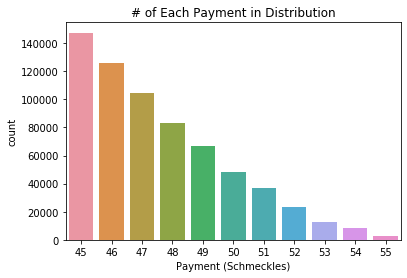

In [4]:
sns.countplot(scoring10[np.where(scoring10 >= 45)]).set_title('# of Each Payment in Distribution')
plt.xlabel('Payment (Schmeckles)')

In [5]:
# Don't change this cell if you expect a non-exception result
# b = np.arange(20)
# twenty_exact_array = np.array([p for p in multiset_permutations(b)])
coin_array_score_demo(20)

[ 0  1  7 20  4 10 16 15 19  6  8  2  9  5 12 18 14 13 17 11  3]
[  1   6  13 -16   6   6  -1   4 -13   2  -6   7  -4   7   6  -4  -1   4
  -6  -8]
121


Unfortunately, the above approach won't work for N=20, as the number of permutations exceeds 2E18, much more than can be held in memory of any sort on my computer (exabyte range). 

Instead, we will create arrays of values 1-20 inclusive in random permutations, then score the trials using the function above. With a large enough number of trials, we can approximate the distribution of scores, and attempt to calculate the mean, standard deviation, and a cumulative probability.

As usual, stackexchange proves to be helpful: [this post](https://stackoverflow.com/questions/45437988/numpy-random-choice-to-produce-a-2d-array-with-all-unique-values/45438143#45438143) provides a clever way to generate a large array faster than iterating and shuffling each trial.

use uint8(0-255) to save a bit of space, as the integers shouldn't exceed 55 for n=10 and 210 for n=20
    - Not a proof: 
        - the maximum score is found by alternating highest descending and lowest ascending
            e.g. 10,1,9,2,8,3,7,4,6,5: score=55
        - any permutation can be reached by repeatedly: swapping the last two elements, 
            and/or moving the last element to the first position
        - that results in the same score, or lowers it compared to the max

In [6]:
def rand_inside_rows(m,n):
    """Create m-row, n-col array that is randomized in each row by the following procedure:
        - create an randomized mxn array
        - use argsort to return an array of ints wherein each row contains the positions of the random elements when sorted
        - add one to each integer in the array (sort returns are indexed from 0)
        Note: it's possible that some of the rand values may collide inside the array created, but argsort will still return
        sensible output for our purposes. This is equally likely to affect any of the individual coin orders in each trial,
        and as such, shouldn't have an effect on the randomness of each trial.
    """
    return (np.random.rand(m,n).argsort(axis=-1).astype('int8') + np.ones((m,1),dtype='int8'))


n=20
scoring20 = score_coins( rand_inside_rows(24800000,n), n)
m = scoring20.mean(), 
std = scoring20.std()

# To find the probability of payment>=45 divide the #payments >=120 by total #payments
p120_plus = scoring20[np.where(scoring20 >= 120)].shape[0] / len(scoring20)

print(f'The mean:{m}\tstddev:{std}\tprobability of payment >= 120: {p120_plus}')

The mean:(143.5033152016129,)	stddev:18.435753516445047	probability of payment >= 120: 0.8996431048387097


C:\Users\way\Anaconda3\lib\site-packages\seaborn\distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


Text(0.5, 1.0, 'Distribution of Payments for N=20')

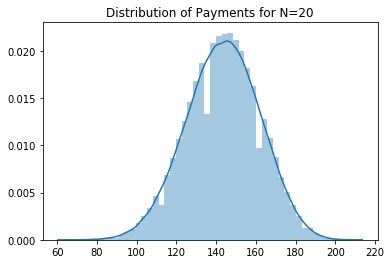

In [7]:
# Brief check to see that the distribution looks as expected
sns.distplot(scoring20[::100]).set_title('Distribution of Payments for N=20')